# Example 5.9 — Crack propogation POD and Additive Measurement Error Model Development

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-11-04  
**Version:** 1.1  

---
## Problem Statement

A fatigue test was conducted on an aluminum sample that had four measurement gauges attached to around
the area where crack propagation would occur. Through the course of the test four sets of crack length mea-
surements were obtained as seen in Table 5.21. A post-test analysis determined the actual lengths of the crack
at ten different stopping points during the test.
Suppose that the **threshold for detection is 0.1 mm** and that the crack propagation data is fit to an exponential
growth model $D(N) = a \cdot e^{bN}$ for simplicity. **Determine the probability of detection and measurement error
models** by way of Equation 5.39. **Assume a logistic model for the POD and an additive measurement error
model.**

---

## Solution:

### Measurement Error Model

Additive error: $y \mid \hat{y} \sim \mathcal{N}\!\big(m\,\hat{y} + c,\ \sigma_{\varepsilon}^2\big)$

### LSQ estimates

| Parameter | Estimate |
|-----------|----------|
| m | 1.0190 |
| c | 0.0054 |
| $\sigma_{\varepsilon}$ | 0.0503 |

### MLE estimates

| Parameter | Estimate | Std. Error | 90% CI low | 90% CI high |
|-----------|----------|------------|----------------|-----------------|
| m | 1.0190 | 1.0000 | -0.6259 | 2.6638 |
| c | 0.0054 | 1.0000 | -1.6395 | 1.6503 |
| $\sigma_{\varepsilon}$ | 0.0503 | 0.0503 | -0.0324 | 0.1330 |

**Information criteria (MLE; No. obs = 23):**  AIC = -66.28,  BIC = -62.87,  AICc = -65.01


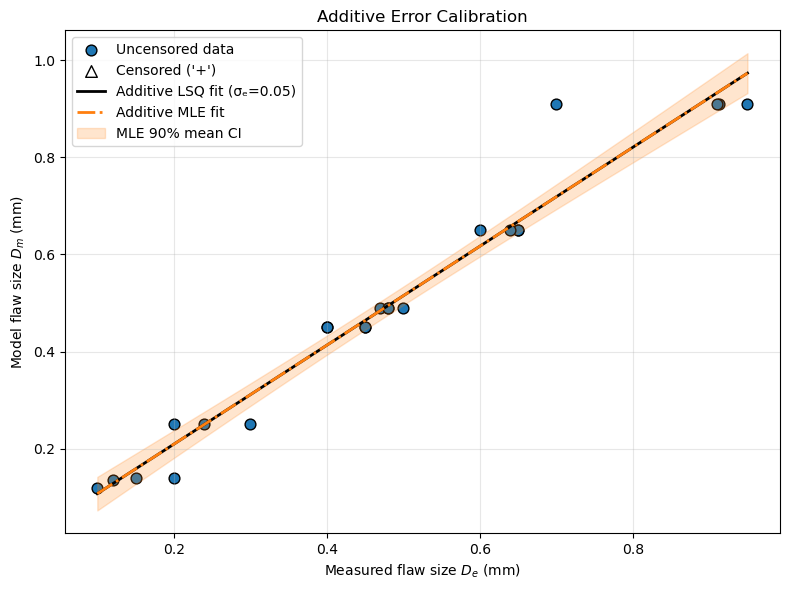

### Probability of Detection (POD) Model: Logistic

Plain log–logistic POD: $POD_{\text{plain}}(x) = \mathrm{expit}\big(\beta_0 + \beta_1 \ln x\big)$.

Left–truncated at $a_{lth}$: $POD(x) = 0,\ x < a_{lth};\quad POD(x) = \dfrac{POD_{\text{plain}}(x) - POD_{\text{plain}}(a_{lth})}{1 - POD_{\text{plain}}(a_{lth})},\ x \ge a_{lth}$.

### LSQ estimates

| Parameter | Estimate |
|-----------|----------|
| $\beta_0$ | 5.8368 |
| $\beta_1$ | 2.6983 |

### MLE estimates

| Parameter | Estimate | Std. Error | 90% CI low | 90% CI high |
|-----------|----------|------------|----------------|-----------------|
| $\beta_0$ | 7.1129 | 2.8615 | 2.4062 | 11.8196 |
| $\beta_1$ | 3.6103 | 1.7756 | 0.6896 | 6.5309 |


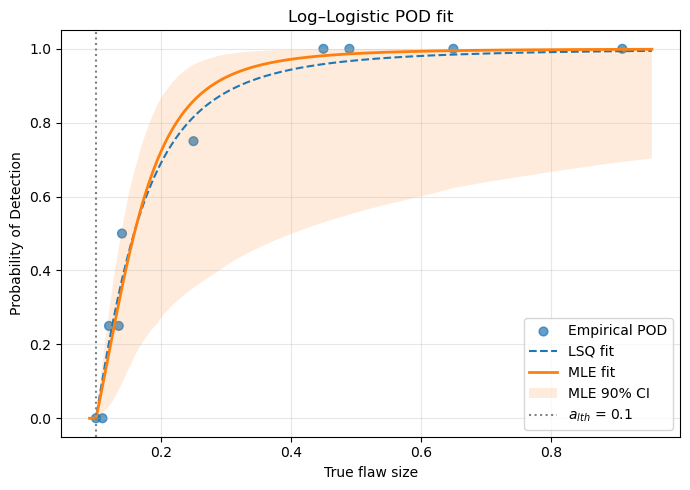

In [3]:
# EXAMPLE 5.9
import sys 
sys.path.append("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module")
from ADT_fitters import Fit_Error_Calibration, Fit_Logistic_POD
import pandas as pd

# --- Load ---
df = pd.read_csv("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/Modarres Chapter Validation/Data/Example_5.9_crack_propogation_data.csv")
gauge_cols = ["Gauge 1", "Gauge 2", "Gauge 3", "Gauge 4"]
df = df.rename(columns={"Actual Crack Length (mm)": "Actual"})
long_df = (df.melt(id_vars=["Cycles", "Actual"], value_vars=gauge_cols, var_name="Gauge", value_name="D_e"))


# Additive, MLE Measurrement Error
cal_fit = Fit_Error_Calibration(
    D_measured=long_df["D_e"],
    D_true=long_df["Actual"],
    model="additive",
    method="MLE",
    CI=0.90,
    random_state=7,
)
cal_fit._plot_calibration(save="5.9_CAL_independent.png")

# MLE Logistic POD
pod_fit = Fit_Logistic_POD(
    D_measured=long_df["D_e"],
    D_true=long_df["Actual"],
    a_lth=0.1,
    method="MLE",
    CI=0.90,
    random_state=7,
)
pod_fit._plot_pod(save="5.9_POD_independent.png")


=== Joint MLE: Degradation + Calibration + POD ===
Success: True  |  NLL: -42.1112
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH

Degradation: D(N)=b*exp(aN)
  a = 0.00278392
  b = 0.0543078

Additive calibration/error: y_cal = m*y_hat + c,  y ~ N(mu, sigma_e^2)
  m = 1.01897
  c = 0.00539987
  sigma_e = 0.050279

POD form = logistic_y, a_lth = 0.1
  beta0 = 7.11291
  beta1 = 3.61029



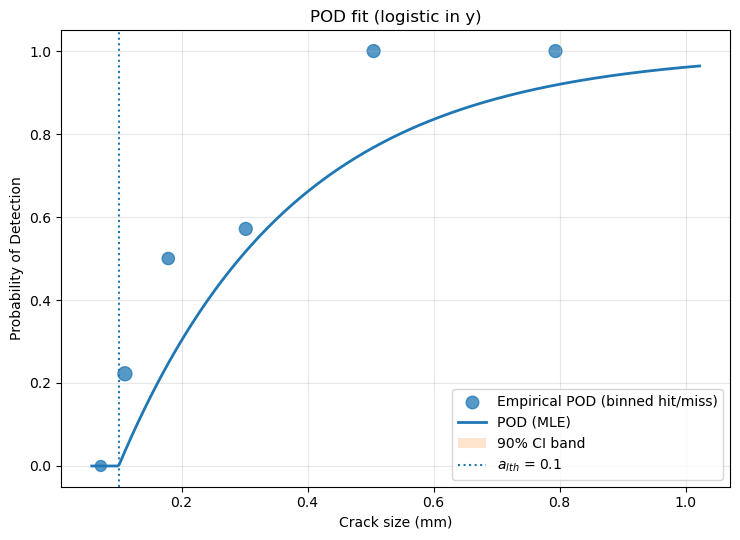

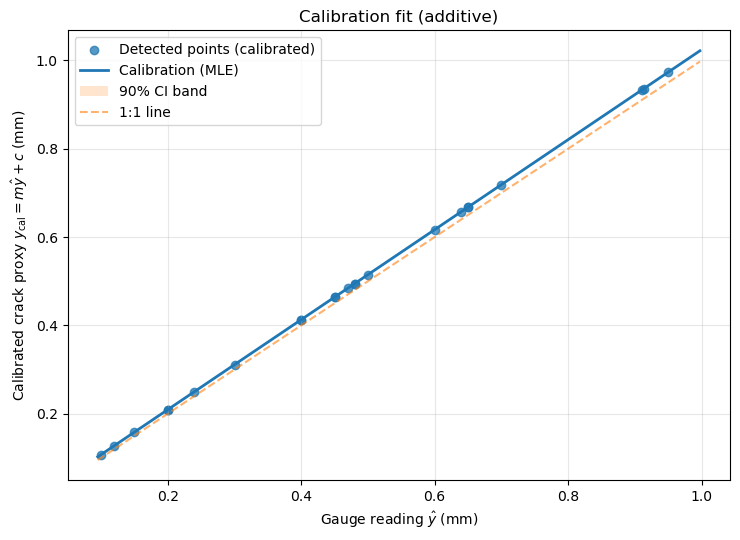

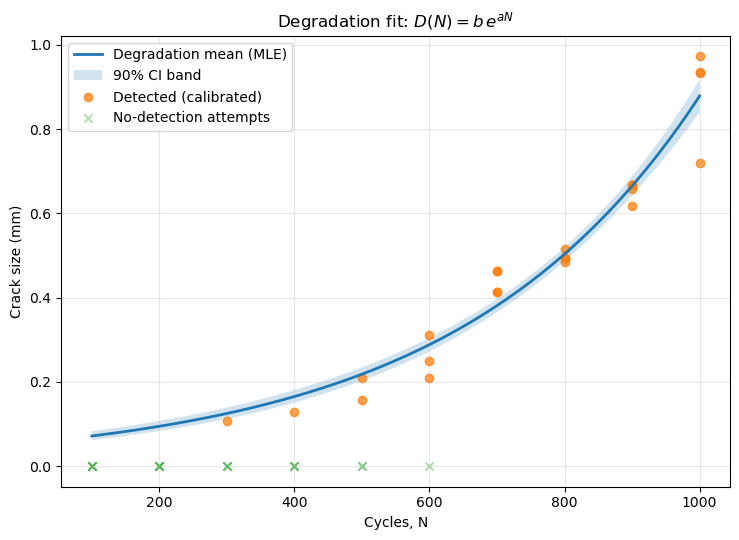

In [2]:
from ADT_fitters import Fit_Degradation_POD_Calibration
joint = Fit_Degradation_POD_Calibration(
    N=long_df["Cycles"],
    y_hat=long_df["D_e"],
    pod_form="logistic_y",
    a_lth=0.1,
    init_from_calibration=cal_fit,
    init_from_pod=pod_fit,
    full_joint=False,     # <- key
    print_results=True
)

joint.plot_results(CI=0.90, ndraw=4000, bins=6, random_state=1)

# or save
joint.plot_results(save_prefix="5.9", show=False)
